In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Actor, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, a_dim))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        #out = torch.tanh(out)
        out= F.softmax(out+1e-10, dim=1)
        return out


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [213]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = Actor(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        # Stabilize training
        self.critic_target = copy.deepcopy(self.critic).to(device)

    def choose_action(self, state):
        self.actor.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state.to(self.device))
            if torch.isnan(action_probs).any():
                print(0)
            dist = Categorical(action_probs)
            action = dist.sample()
        return action.item(), action_probs.squeeze().detach().cpu().numpy()

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return
        for i in range(self.grad_steps):
            batch = random.sample(self.buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32).to(self.device)
            actions = torch.tensor(actions, dtype=torch.float32).squeeze().to(self.device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
            dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
            #print(dones)
            
            # Critic train
            self.critic.train()
            
            with torch.no_grad():
                probs = self.actor(next_states)
                dist = Categorical(probs)
                sampled_actions = dist.sample()
                next_actions_log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
                q1_next, q2_next = self.critic_target(next_states, probs)
                min_q_next = torch.min(q1_next, q2_next)
                #print((torch.ones_like(dones)-dones) (min_q_next - self.alpha * next_actions_log_probs))
                target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones)*(min_q_next - self.alpha * next_actions_log_probs)#.sum(-1, keepdim=True))
                
            q1, q2 = self.critic(states, actions)
            
            critic_loss = F.mse_loss(q1, target_q_value.detach()) + F.mse_loss(q2, target_q_value.detach())

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Actor train
            self.actor.train()

            probs = self.actor(states)
            dist = Categorical(probs)
            sampled_actions = dist.sample()
            log_probs = dist.log_prob(sampled_actions)#.sum(-1, keepdim=True)
            q1_actor, q2_actor = self.critic(states, probs)
            min_q_actor = torch.min(q1_actor, q2_actor)
            
            actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        #print(critic_loss.item(), actor_loss.item())
        return critic_loss.item(), actor_loss.item()

    def add_elements_to_buffer(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

In [214]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [215]:
a=torch.zeros(2,4).to(device)
b=torch.zeros(1,2).to(device)
#agent.critic(a,b)

## Cartpole

In [216]:
env = gym.make('CartPole-v1', new_step_api=True)
env.seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [217]:
def cartpole_training(agent, early_stop=False, n_episodes=2000, max_t=1000, gamma=1.0, print_every=100, training_interval=10):
    scores_deque = deque(maxlen=100)
    scores = []
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        rewards = []
        update_interval = 0
        for t in range(max_t):
            # Sample the action from current policy
            action, probs = agent.choose_action(state)
            new_state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            agent.add_elements_to_buffer(state, probs, reward, new_state, done)
            state = new_state
            update_interval += 1
            if t % training_interval == 0:
                agent.train(update_interval)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        if episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_deque)))
            break
    
    return scores

In [218]:
agent.actor.f(torch.tensor([[-0.0407, -0.2380,  0.0140,  0.4236]]).to(device))

tensor([[-2.0613,  2.4101]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [219]:
agent = SAC(state_dim, action_dim, buffer_capacity=100000, hidden_dim_actor = 128, hidden_dim_critic=128, num_layer_actor=1, num_layer_critic=1, lr_act=1e-4, lr_crit=1e-4, alpha=0.2, tau=0.05, batch_size=5, grad_steps=1, device=device)
scores = cartpole_training(agent, n_episodes=2000, max_t=1000, training_interval=2)
env.close()

C:\Users\guill\AppData\Local\Temp\ipykernel_9384\2597092729.py:69: UserWarning: Using a target size (torch.Size([5, 5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(q1, target_q_value.detach()) + F.mse_loss(q2, target_q_value.detach())


Episode 0	Average Score: 9.00
Episode 100	Average Score: 9.82
Episode 200	Average Score: 9.47
Episode 300	Average Score: 9.33


KeyboardInterrupt: 

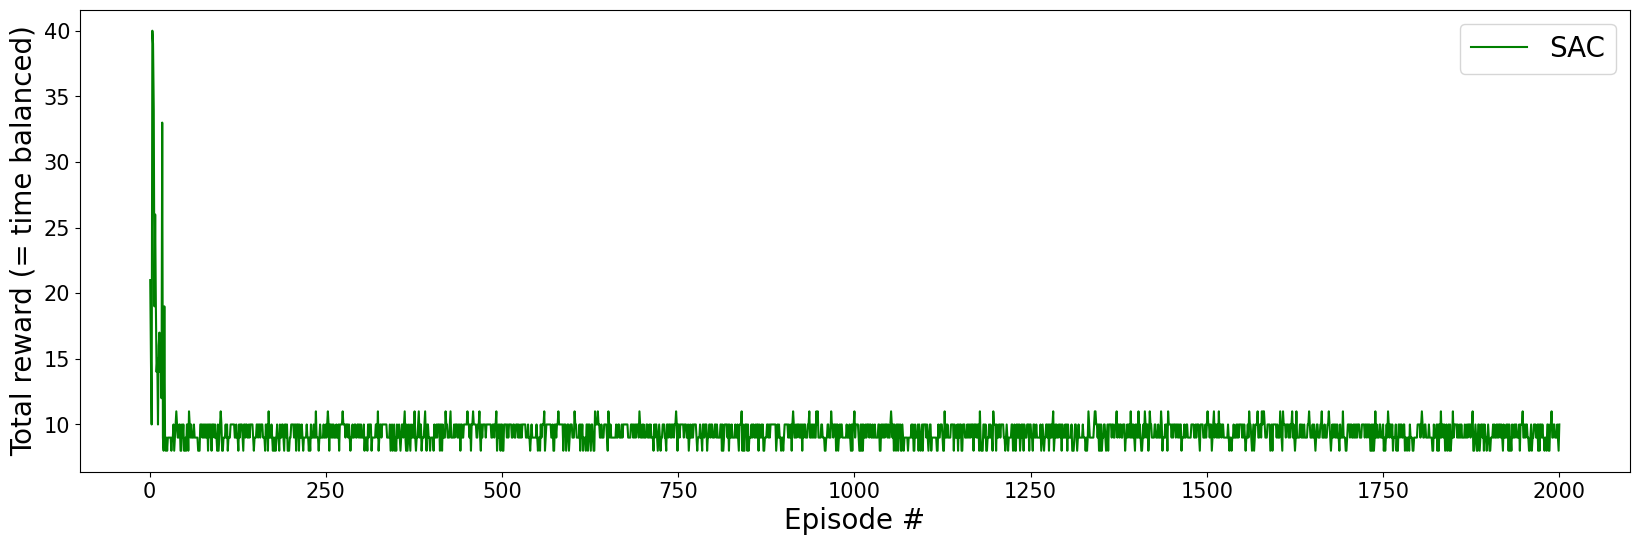

In [ ]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores) + 1), scores, color='green', label='SAC')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()